# Plots for ta - all models

In [35]:
import cftime
import datetime
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import time
import xarray as xr

### Input files

In [36]:
# UKESM

UK_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/ta/ta_Amon_UKESM1-0-LL_ssp370SST_r1i1p1f2_gn_201501-209912.nc'
UK_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/ta/ta_Amon_UKESM1-0-LL_ssp370SST-lowBC_r1i1p1f2_gn_201501-209912.nc'

UKESM_base = xr.open_dataset(UK_filename_base)
UKESM_signal = xr.open_dataset(UK_filename_signal)

# MIROC6

MIR_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/ta/ta_Amon_MIROC6_ssp370SST_r1i1p1f1_gn_201501-209912.nc'
MIR_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/ta/ta_Amon_MIROC6_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

MIROC_base = xr.open_dataset(MIR_filename_base)
MIROC_signal = xr.open_dataset(MIR_filename_signal)

# MPI-ESM

MPI_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/ta/ta_Amon_MPI-ESM-1-2-HAM_ssp370SST_r1i1p1f1_gn_201501-205512.nc'
MPI_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/ta/ta_Amon_MPI-ESM-1-2-HAM_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

MPI_ESM_base = xr.open_dataset(MPI_filename_base)
MPI_ESM_signal = xr.open_dataset(MPI_filename_signal)

In [37]:
UKESM_base

<xarray.Dataset>
Dimensions:    (time: 1020, bnds: 2, lon: 192, lat: 144, plev: 19)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2099-12-16 00:00:00
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    ta         (time, plev, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.1.0 (https://mpi...
    source:                 UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mode\n...
    institution:            Natural Environment Research Council, STFC-RAL, H...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            AerChemMIP
    branch_method:          standard
    ...                     ...
    variable_name:          ta
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Natural Environm...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/10ec1d7f-3562-4d38-af0b-b165ba275de1
    CDO:                    Climate Data Operators version 2.1.0 (https://mpi...

### Convert units

In [38]:
def convert_to_celsius(ds):
    ds['ta'] = ds['ta'] - 273.15
    ds['ta'].attrs.update({'units': 'C',
    'long_name': 'Celsius'})  # Update attributes
    return ds

MIROC_base, MIROC_signal = convert_to_celsius(MIROC_base), convert_to_celsius(MIROC_signal)
MPI_ESM_base, MPI_ESM_signal = convert_to_celsius(MPI_ESM_base), convert_to_celsius(MPI_ESM_signal)
UKESM_base, UKESM_signal = convert_to_celsius(UKESM_base), convert_to_celsius(UKESM_signal)

### Define limits and functions

In [39]:
def slice_lat(ds):
    ds = ds.sel(lat=slice(8, 30))
    return ds

MIROC_base_filtered_india, MIROC_signal_filtered_india = slice_lat(MIROC_base), slice_lat(MIROC_signal)
MPI_ESM_base_filtered_india, MPI_ESM_signal_filtered_india = slice_lat(MPI_ESM_base), slice_lat(MPI_ESM_signal)
UKESM_base_filtered_india, UKESM_signal_filtered_india = slice_lat(UKESM_base), slice_lat(UKESM_signal)

In [40]:
def slice_lat(ds):
    ds = ds.sel(lat=slice(30, 45))
    return ds

MIROC_base_filtered_upper, MIROC_signal_filtered_upper = slice_lat(MIROC_base), slice_lat(MIROC_signal)
MPI_ESM_base_filtered_upper, MPI_ESM_signal_filtered_upper = slice_lat(MPI_ESM_base), slice_lat(MPI_ESM_signal)
UKESM_base_filtered_upper, UKESM_signal_filtered_upper = slice_lat(UKESM_base), slice_lat(UKESM_signal)

In [43]:
def calculate_annual_means(dataset, start_year, end_year):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"
    return dataset.sel(time=slice(start_date, end_date)).resample(time='A').mean(dim='time')

In [44]:
def calculate_weighted_means(ds):
    weights = np.cos(np.deg2rad(ds['lat']))
    weights_expanded = weights.expand_dims({"time": ds['time'], 
                                            "plev": ds['plev'], 
                                            "lon": ds['lon']})
    ds_weighted = ds['ta'] * weights_expanded.transpose('time', 'plev', 'lat', 'lon')
    return ds_weighted

In [45]:
def calculate_anomaly(ds1, ds2):
    # Calculate the weighted means
    ds1_weighted_mean = calculate_weighted_means(ds1).mean(dim='time')
    ds2_weighted_mean = calculate_weighted_means(ds2).mean(dim='time')

    # Calculate the anomaly
    anomaly = ds2_weighted_mean - ds1_weighted_mean

    # Ensure the anomaly is transposed to have dimensions in the order: ('plev', 'lat', 'lon')
    return anomaly.transpose('plev', 'lat', 'lon')


In [47]:
def plot_data(ax, ds_anomaly, model_base, model_signal, start_year, end_year):
    
    # Calculate annual means for the t-test
    annual_means_base = calculate_annual_means(model_base, start_year, end_year).mean(dim='lat')
    annual_means_signal = calculate_annual_means(model_signal, start_year, end_year).mean(dim='lat')
    
    # Perform t-test
    t_stat, p_value = ttest_ind(annual_means_base['ta'].values, annual_means_signal['ta'].values,
                                axis=0, nan_policy='omit')

    # Identify significant points
    alpha = 0.05
    significant_points = p_value < alpha
    
    # Ensure that ds_anomaly is a 2D array (Pressure x Longitude)
    ds_anomaly_2d = ds_anomaly.mean(dim='lat')
    
    cmap = mpl.colormaps['RdBu_r']
    norm = mcolors.TwoSlopeNorm(vmin=V_MIN, vcenter=0, vmax=V_MAX)

    # Create the plot
    im = ax.pcolormesh(ds_anomaly_2d['lon'], ds_anomaly_2d['plev'], ds_anomaly_2d, 
                       cmap=cmap, norm=norm, shading='auto')

    # Overlay significant points if necessary
    if significant_points.any():
        lon, plev = np.meshgrid(ds_anomaly['lon'].values, ds_anomaly['plev'].values)
        ax.scatter(lon[significant_points], plev[significant_points], c='k', s=2)
    
    # Invert y-axis for pressure
    ax.invert_yaxis()

    # Set labels and title
    ax.set_title(f'{start_year}-{end_year}', fontsize=35)
    ax.set_xlabel('Longitude', fontsize=30)
    ax.set_ylabel('Pressure (Pa)', fontsize=30)
    ax.tick_params(labelsize=25)

    return im

### Define the intervals for each model

In [ ]:
UKESM_intervals = [(2015, 2034), (2035,2054), (2055, 2074), (2075, 2094)]
MIROC6_intervals = [(2015, 2034), (2035,2054)]
MPI_ESM_intervals = [(2015, 2034), (2035,2054)]

V_MIN, V_MAX = -0.3, 0.3

# Curtain plots

### lat=8-30 (INDIA)

/tmp/ipykernel_1942797/2454251072.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.92])


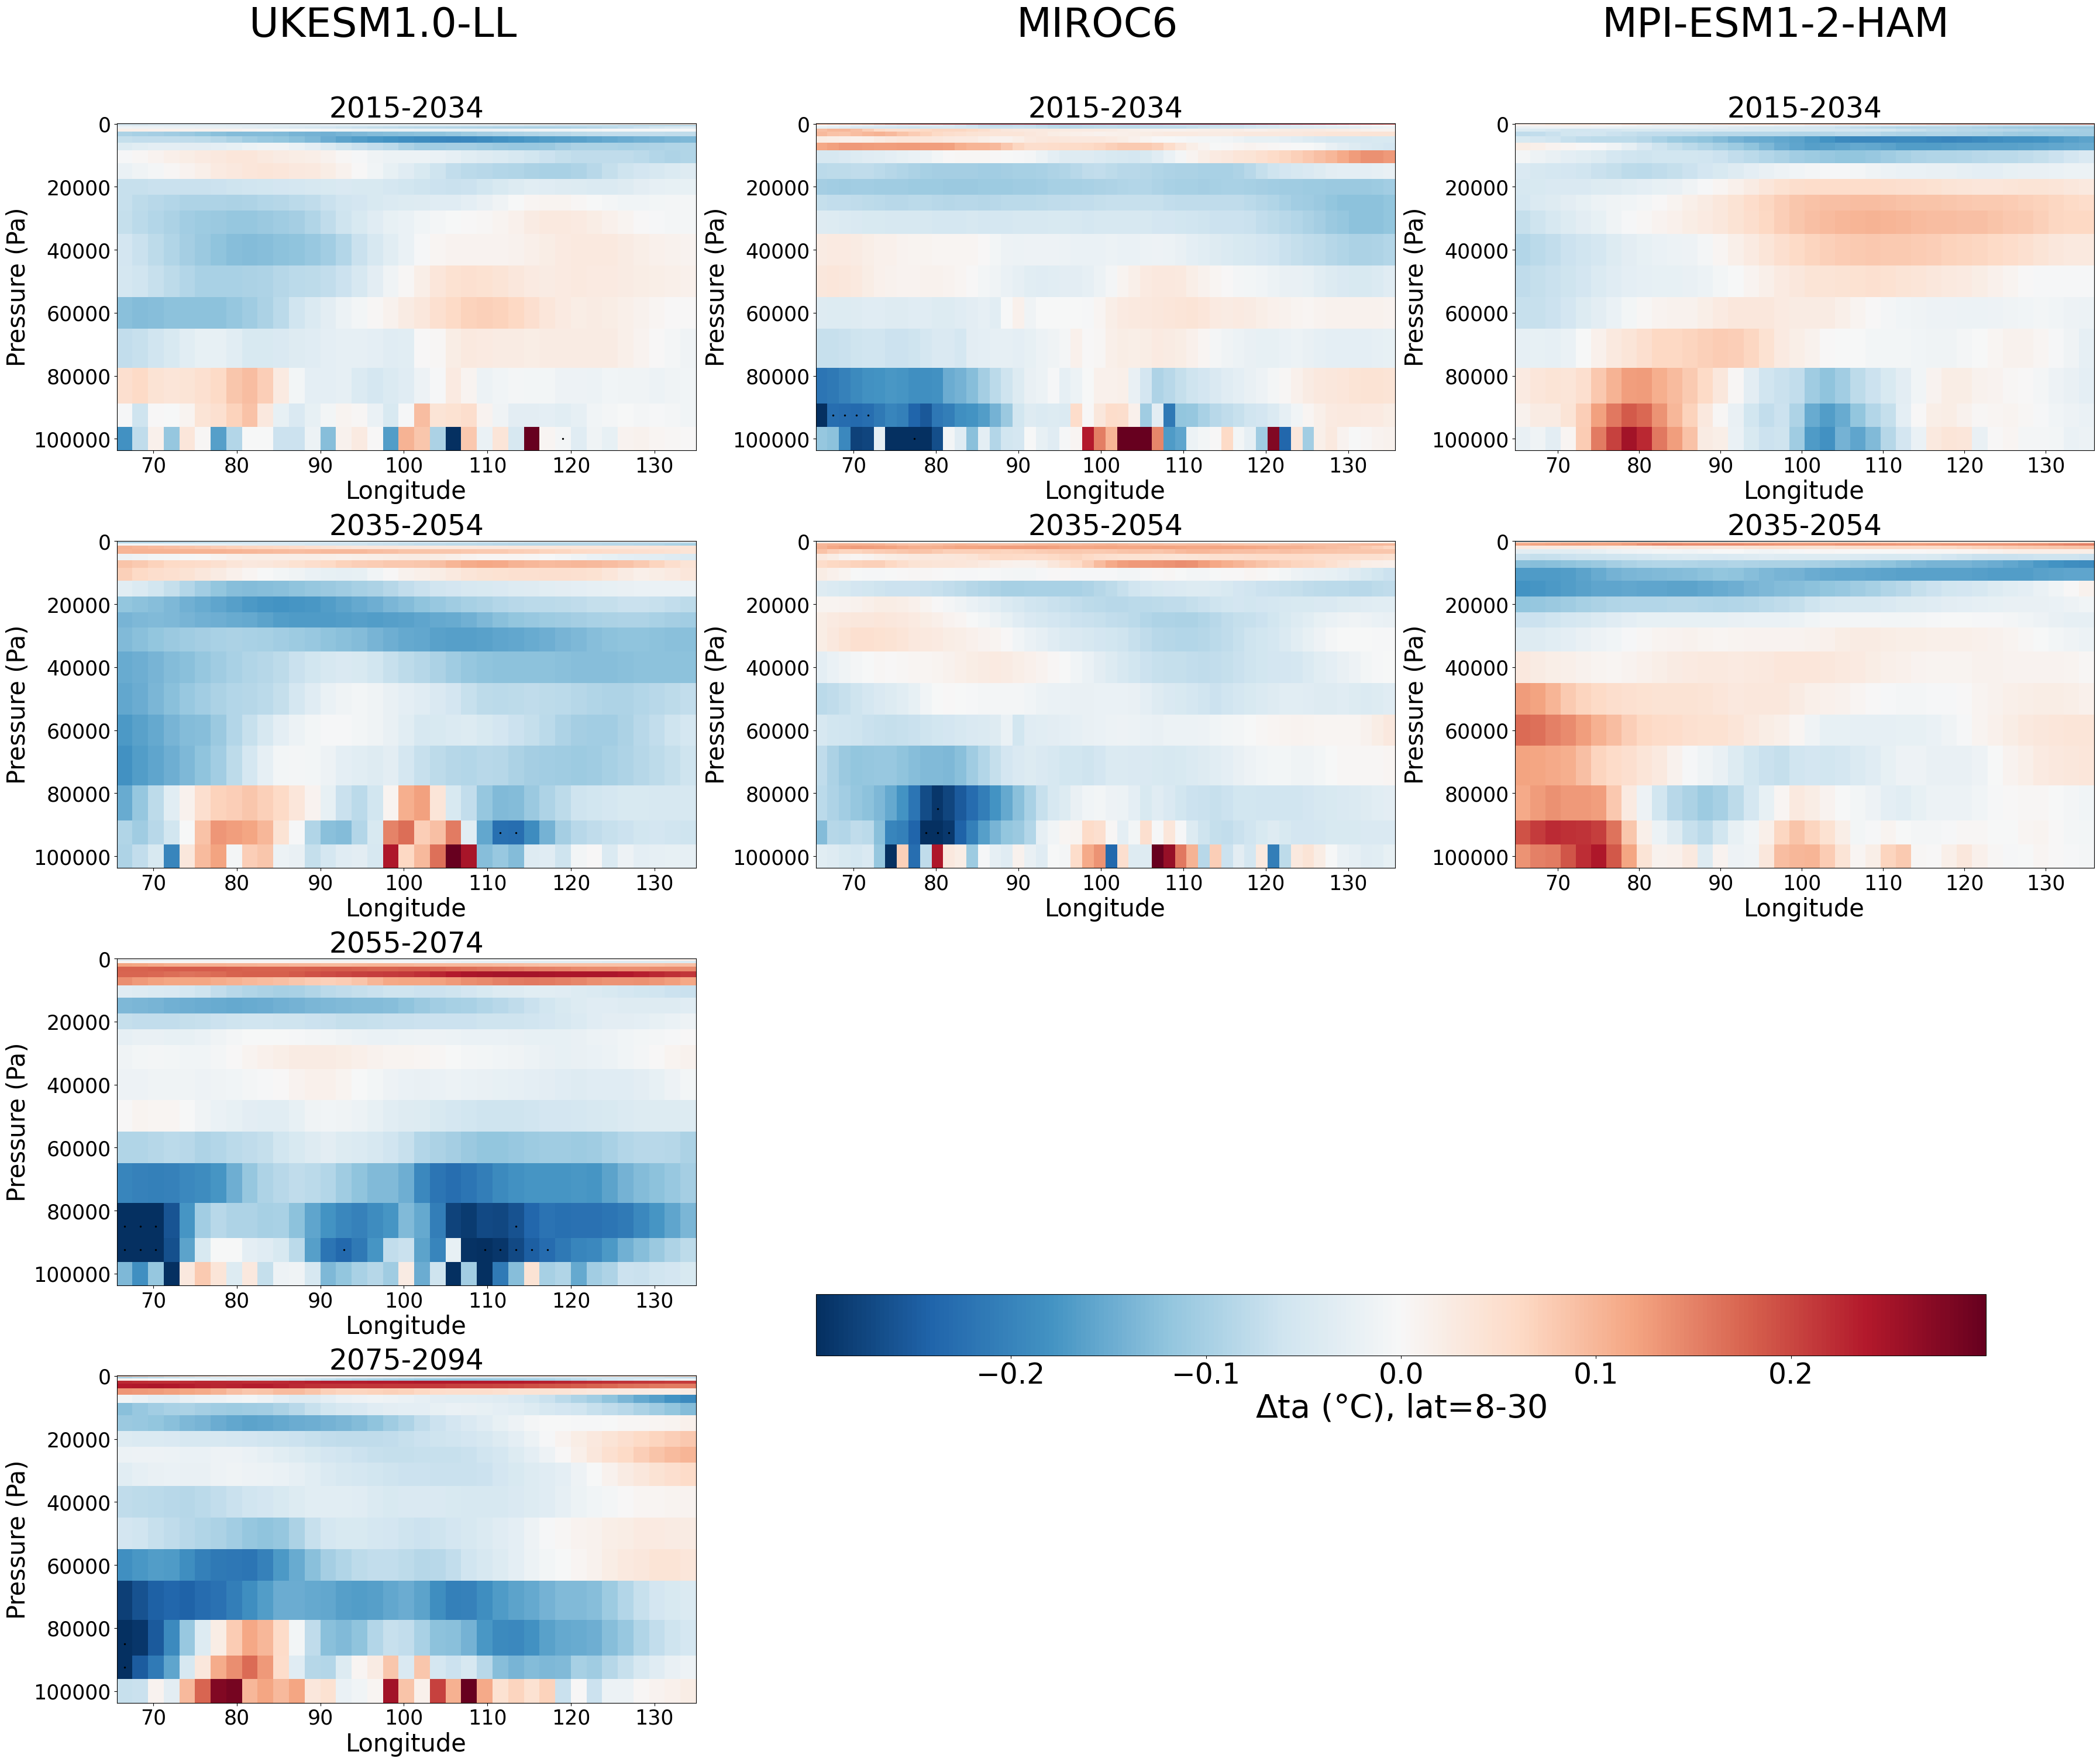

In [48]:
# Create the grid of subplots
fig, axes = plt.subplots(max(len(UKESM_intervals), len(MIROC6_intervals), len(MPI_ESM_intervals)), 
                         3, figsize=(40, 35))  

# Function to safely get an axis (for models with fewer intervals)
def safe_axis(axes, row, col):
    if row < axes.shape[0]:
        return axes[row, col]
    else:
        return None

# Plotting for UKESM
for i, (start_year, end_year) in enumerate(UKESM_intervals):
    ax = safe_axis(axes, i, 0)  # First column for UKESM
    if ax:
        UKESM_base_interval = UKESM_base_filtered_india.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        UKESM_signal_interval = UKESM_signal_filtered_india.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        UKESM_anomaly = calculate_anomaly(UKESM_base_interval, UKESM_signal_interval)
        last_im = plot_data(ax, UKESM_anomaly, UKESM_base_interval, UKESM_signal_interval, start_year, end_year)

# Plotting for MIROC
for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    ax = safe_axis(axes, i, 1)  # Second column for MIROC
    if ax:
        MIROC_base_interval = MIROC_base_filtered_india.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MIROC_signal_interval = MIROC_signal_filtered_india.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MIROC_anomaly = calculate_anomaly(MIROC_base_interval, MIROC_signal_interval)
        plot_data(ax, MIROC_anomaly, MIROC_base_interval, MIROC_signal_interval, start_year, end_year)

# Plotting for MPI-ESM
for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    ax = safe_axis(axes, i, 2)  # Third column for MPI-ESM
    if ax:
        MPI_ESM_base_interval = MPI_ESM_base_filtered_india.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MPI_ESM_signal_interval = MPI_ESM_signal_filtered_india.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MPI_ESM_anomaly = calculate_anomaly(MPI_ESM_base_interval, MPI_ESM_signal_interval)
        plot_data(ax, MPI_ESM_anomaly, MPI_ESM_base_interval, MPI_ESM_signal_interval, start_year, end_year)
        
# Hide the unused axes for MIROC and MPI-ESM
for i in range(len(MIROC6_intervals), len(UKESM_intervals)):
    axes[i, 1].axis('off')  # Hide MIROC extra subplots
for i in range(len(MPI_ESM_intervals), len(UKESM_intervals)):
    axes[i, 2].axis('off')  # Hide MPI-ESM extra subplots

# Adjust the position (left, bottom), width, and height of the colorbar
cbar_ax = fig.add_axes([0.4, 0.3, 0.5, 0.03])  # Adjust as needed for aesthetics

if last_im is not None:
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=35)
    cbar.set_label(r'$\Delta$ta (°C), lat=8-30', fontsize=40)

# Adjust layout and labels
fig.text(0.215, 0.95, 'UKESM1.0-LL', ha='center', va='center', fontsize=50)
fig.text(0.52, 0.95, 'MIROC6', ha='center', va='center', fontsize=50)
fig.text(0.81, 0.95, 'MPI-ESM1-2-HAM', ha='center', va='center', fontsize=50)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.92])
plt.show()

### lat=30-45 (CHINA)

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_basic.py:1438: RuntimeWarning: divide by zero encountered in divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/scipy/stats/_mstats_

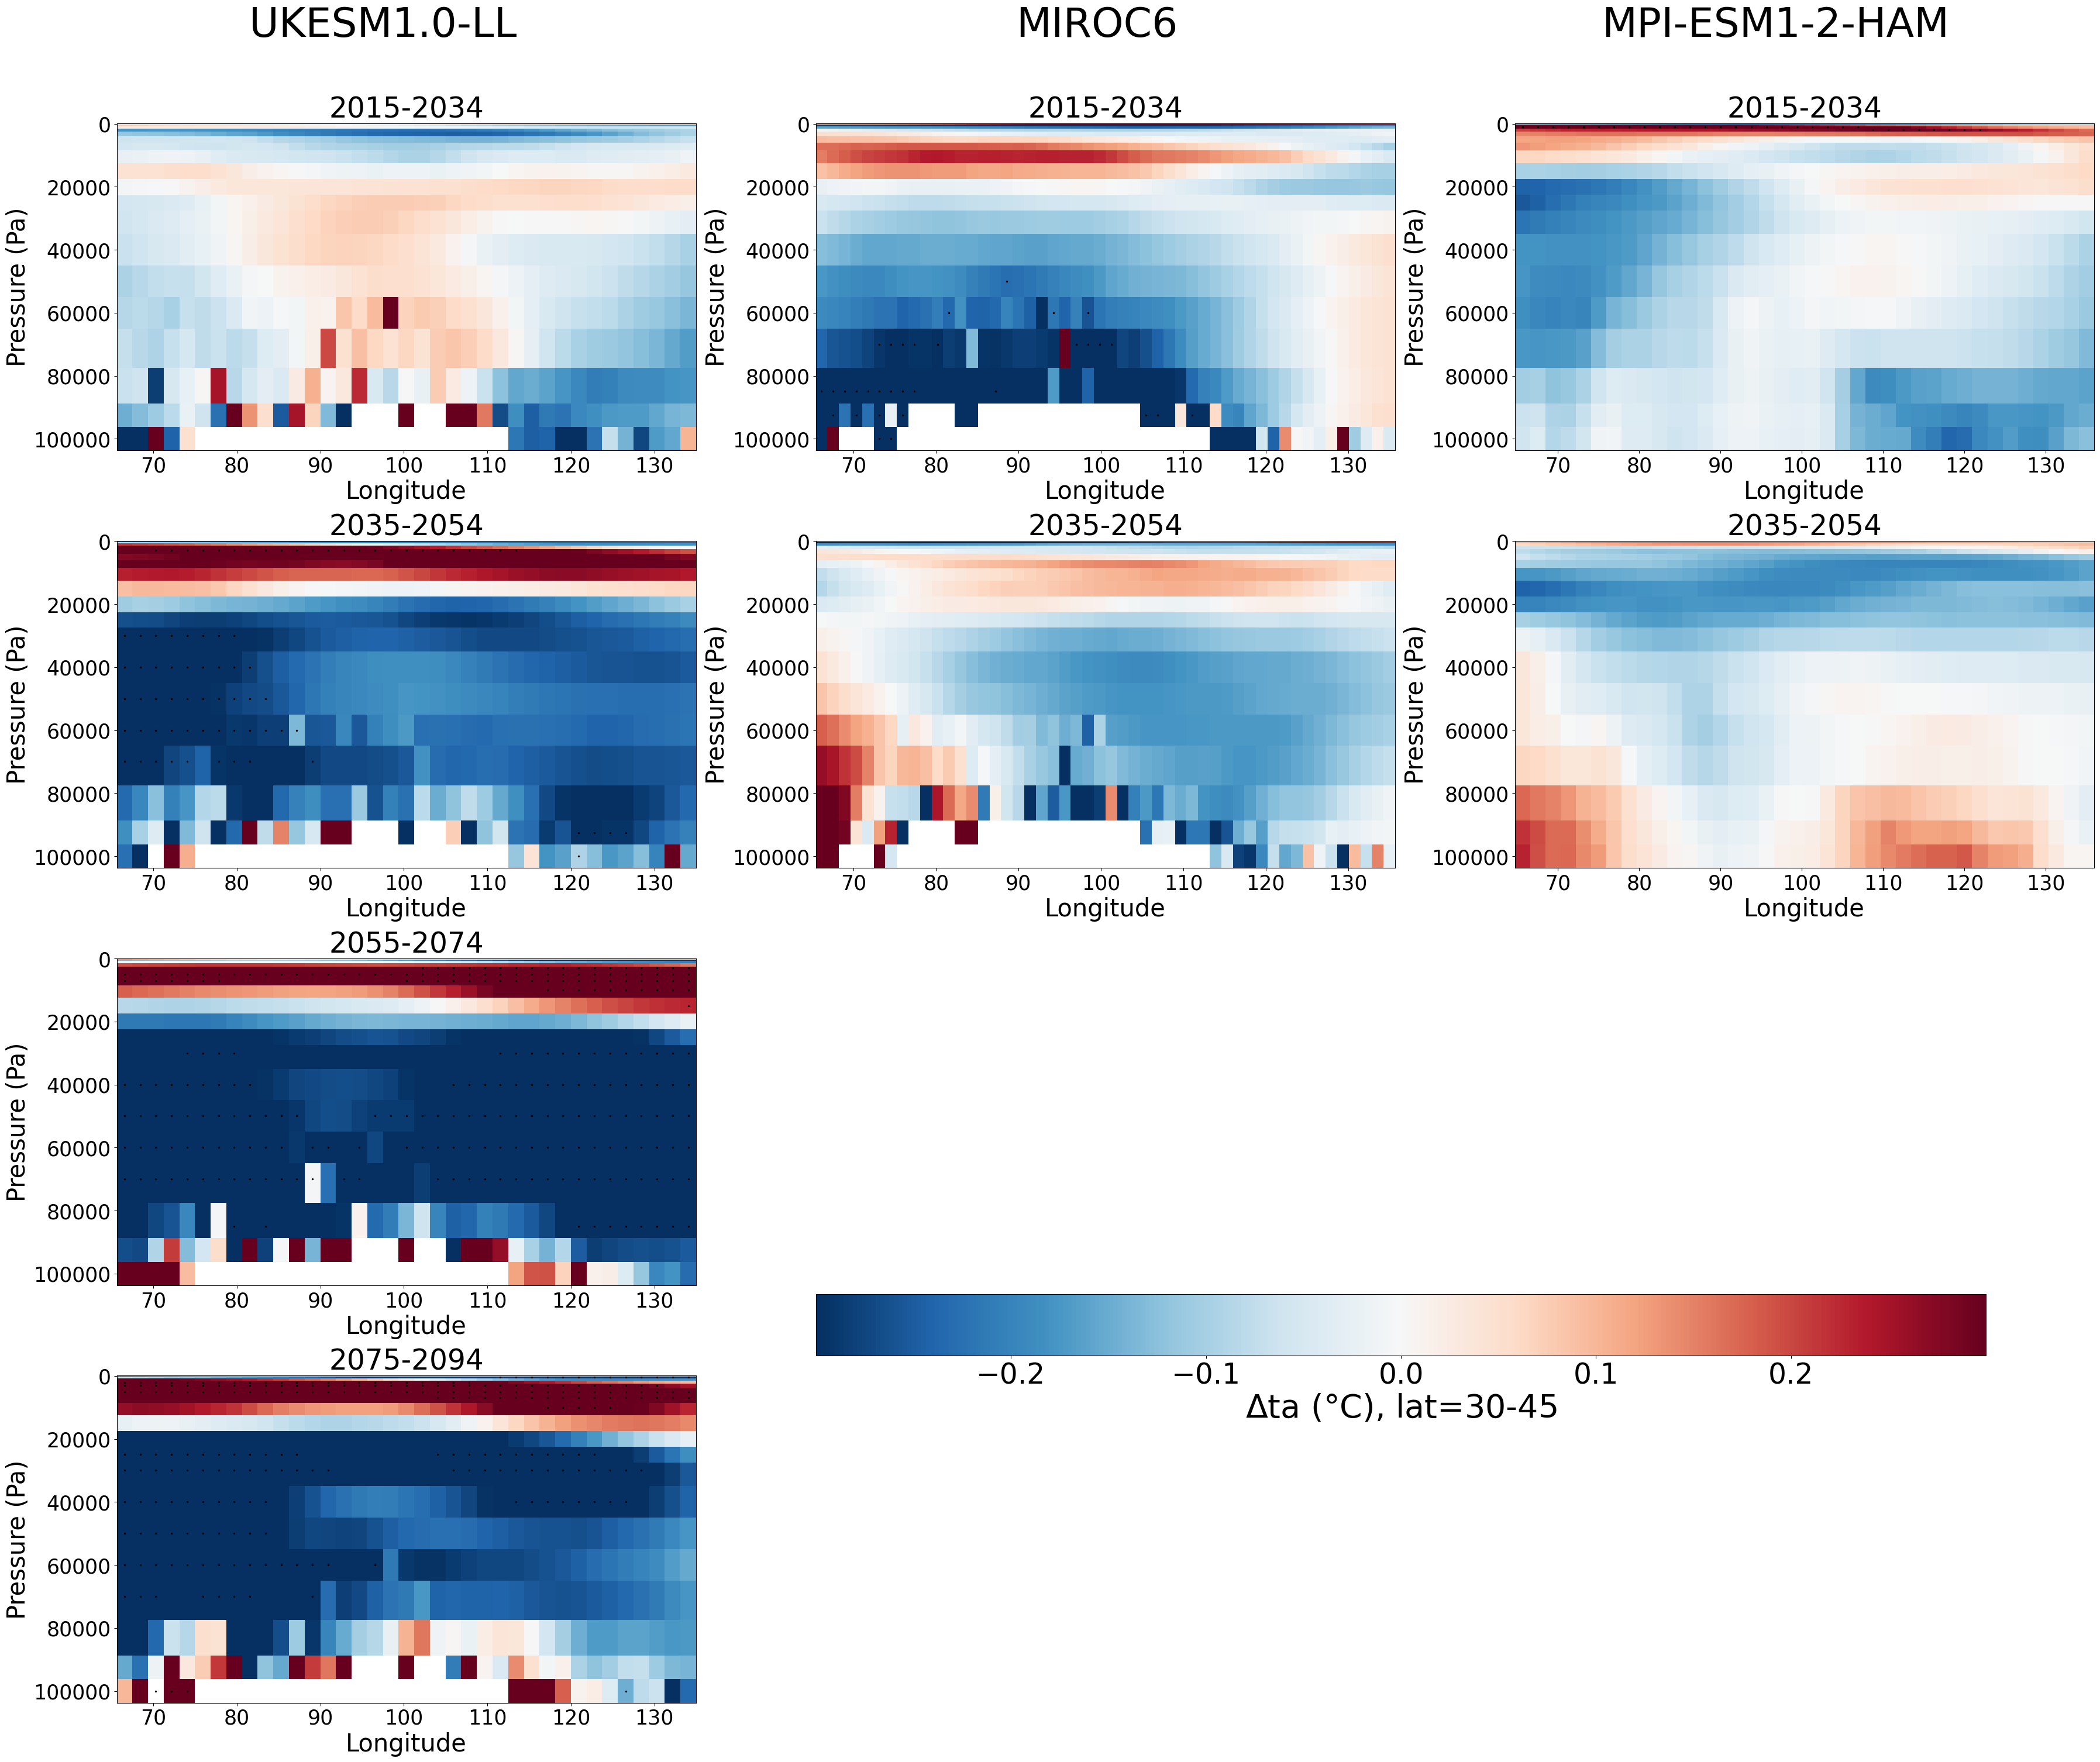

In [49]:
# Create the grid of subplots
fig, axes = plt.subplots(max(len(UKESM_intervals), len(MIROC6_intervals), len(MPI_ESM_intervals)), 
                         3, figsize=(40, 35))  

# Function to safely get an axis (for models with fewer intervals)
def safe_axis(axes, row, col):
    if row < axes.shape[0]:
        return axes[row, col]
    else:
        return None

# Plotting for UKESM
for i, (start_year, end_year) in enumerate(UKESM_intervals):
    ax = safe_axis(axes, i, 0)  # First column for UKESM
    if ax:
        UKESM_base_interval = UKESM_base_filtered_upper.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        UKESM_signal_interval = UKESM_signal_filtered_upper.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        UKESM_anomaly = calculate_anomaly(UKESM_base_interval, UKESM_signal_interval)
        last_im = plot_data(ax, UKESM_anomaly, UKESM_base_interval, UKESM_signal_interval, start_year, end_year)

# Plotting for MIROC
for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    ax = safe_axis(axes, i, 1)  # Second column for MIROC
    if ax:
        MIROC_base_interval = MIROC_base_filtered_upper.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MIROC_signal_interval = MIROC_signal_filtered_upper.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MIROC_anomaly = calculate_anomaly(MIROC_base_interval, MIROC_signal_interval)
        plot_data(ax, MIROC_anomaly, MIROC_base_interval, MIROC_signal_interval, start_year, end_year)

# Plotting for MPI-ESM
for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    ax = safe_axis(axes, i, 2)  # Third column for MPI-ESM
    if ax:
        MPI_ESM_base_interval = MPI_ESM_base_filtered_upper.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MPI_ESM_signal_interval = MPI_ESM_signal_filtered_upper.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"), lon=slice(65, 135))
        MPI_ESM_anomaly = calculate_anomaly(MPI_ESM_base_interval, MPI_ESM_signal_interval)
        plot_data(ax, MPI_ESM_anomaly, MPI_ESM_base_interval, MPI_ESM_signal_interval, start_year, end_year)
        
# Hide the unused axes for MIROC and MPI-ESM
for i in range(len(MIROC6_intervals), len(UKESM_intervals)):
    axes[i, 1].axis('off')  # Hide MIROC extra subplots
for i in range(len(MPI_ESM_intervals), len(UKESM_intervals)):
    axes[i, 2].axis('off')  # Hide MPI-ESM extra subplots

# Adjust the position (left, bottom), width, and height of the colorbar
cbar_ax = fig.add_axes([0.4, 0.3, 0.5, 0.03])  # Adjust as needed for aesthetics

if last_im is not None:
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=35)
    cbar.set_label(r'$\Delta$ta (°C), lat=30-45', fontsize=40)

# Adjust layout and labels
fig.text(0.215, 0.95, 'UKESM1.0-LL', ha='center', va='center', fontsize=50)
fig.text(0.52, 0.95, 'MIROC6', ha='center', va='center', fontsize=50)
fig.text(0.81, 0.95, 'MPI-ESM1-2-HAM', ha='center', va='center', fontsize=50)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.92])
plt.show()